(608, 608, 3)


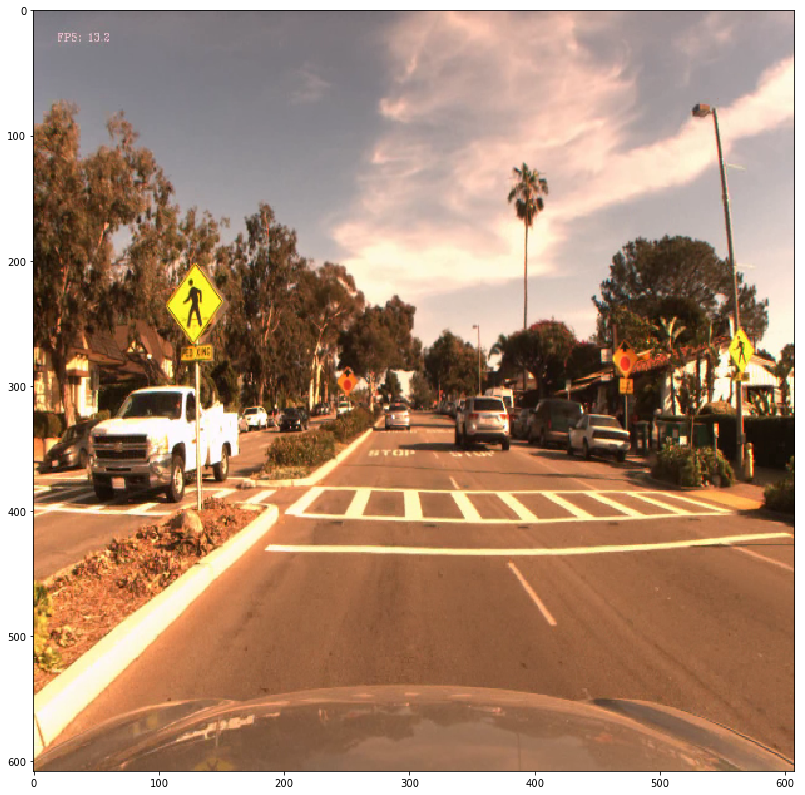

In [1]:
import cv2
import matplotlib.pyplot as plt
from utils.image_handler import preprocess_img
%matplotlib inline

path = '/home/ubuntu/dataset/lisa/training/2014-05-01_17-03/2/frameAnnotations-2.avi_annotations/pedestrianCrossing_1404948572.avi_image4.png'

img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (int(1280/2),int(960/2)))
img = cv2.resize(img, (608, 608))

plt.figure(figsize=(14, 14))
plt.imshow(img)
print(img.shape)

In [2]:
import numpy as np
import cv2

class Box():
    def __init__(self, x1, y1, x2, y2, label, score):
        self.x1 = int(x1)
        self.x2 = int(x2)
        self.y1 = int(y1)
        self.y2 = int(y2)
        self.cls = str(label)
        self.score = float(score)

        
def draw(img, boxes, color=[0, 255, 0], thickness=1):
    result = np.copy(img)
    
    for box in boxes:
        p1 = (box.x1, box.y1)
        p2 = (box.x2, box.y2)
        if color is 'random':
            color = np.random.randint(0, 255, [3])
        result = cv2.rectangle(result, p1, p2, color=color, thickness=thickness)
    return result
# dog    = Box(70, 258, 209, 356, 'Dog', 0.79)
# person = Box(190, 98, 271, 379, 'Person', 0.81)
# horse  = Box(399, 128, 605, 352, 'Horse', 0.89)
# boxes = [dog, person, horse]
# result = draw(img, boxes, color=np.random.randint(0, 255, [3]), thickness=3)
# plt.figure(figsize=(15, 15))
# plt.imshow(result)

In [3]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model, Model
from keras.layers import Conv2D
from keras.regularizers import l2
from cfg import *
from model.yolov2 import YOLOv2, darknet19
from model.net_builder import conv_block

K.clear_session()  # to avoid duplicating model
# N_CLASSES = 80
# ANCHORS   = np.array(((0.57273, 0.677385), (1.87446, 2.06253), 
#                       (3.33843, 5.47434), (7.88282, 3.52778), (9.77052, 9.16828)))

with tf.device('/cpu:0'):
    yolov2 = YOLOv2(feature_extractor=darknet19(input_size=(None, None, 3)), num_anchors=N_ANCHORS, num_classes=N_CLASSES)
    # Cut last layer
    topless_model = yolov2.model.layers[-2].output   

    # # dd a few new Conv2D layers for Traffic Sign Detection
    # traffic_sign_detector = Conv2D(filters=512,padding='same',
    #                                kernel_size=(3, 3), 
    #                                kernel_initializer='he_uniform',
    #                                activation='relu')(topless_model)

    new_conv_block    = conv_block(topless_model, filters=512, kernel_size=(3, 3), padding='same')
    traffic_sign_detector = Conv2D(filters=(N_ANCHORS* (N_CLASSES + 5)),
                                   kernel_size=(1, 1), 
                                   kernel_regularizer=l2(5e-4), 
                                   kernel_initializer='he_uniform', activation='linear',
                                   name='yolov2')(new_conv_block)

    # Build a new Model for training
    model = Model(yolov2.model.input, traffic_sign_detector)
    model.load_weights('yolov2.weights')

Using TensorFlow backend.


In [4]:
# Preprocess input
input_img = img / 255. 
input_img = np.expand_dims(input_img, 0)

# Making prediction
netout = model.predict(input_img)

netshape = np.shape(netout)
netout = np.reshape(netout, [-1, netshape[1], netshape[2], 5, N_CLASSES+5])

GRID_H, GRID_W = netout.shape[1:3]
height, width ,c  = img.shape
print(np.shape(netout))

(1, 19, 19, 5, 36)


In [5]:
image_shape = img.shape

# Create GRID-cell map
cx = tf.cast((K.arange(0, stop=GRID_W)), dtype=tf.float32)
cx = K.tile(cx, [GRID_H])
cx = K.reshape(cx, [-1, GRID_H, GRID_W, 1])

cy = K.cast((K.arange(0, stop=GRID_H)), dtype=tf.float32)
cy = K.reshape(cy, [-1, 1])
cy = K.tile(cy, [1, GRID_W])  
cy = K.reshape(cy, [-1])    
cy = K.reshape(cy, [-1, GRID_H, GRID_W, 1])

c_xy = tf.stack([cx, cy], -1)
c_xy = tf.to_float(c_xy)


anchors_tensor = tf.to_float(K.reshape(K.variable(ANCHORS), [1, 1, 1, 5, 2]))
netout_size   = tf.to_float(K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2]))

box_xy          = K.sigmoid(netout[..., :2])
box_wh          = K.exp(netout[..., 2:4])
box_confidence  = K.sigmoid(netout[..., 4:5])
box_class_probs = K.softmax(netout[..., 5:])

# Adjust predictions to each spatial grid point and anchor size.
box_xy = (box_xy + c_xy) / netout_size
box_wh = box_wh * anchors_tensor / netout_size
box_mins  = box_xy - (box_wh / 2.)
box_maxes = box_xy + (box_wh / 2.)

# Y1, X1, Y2, X2
boxes   = K.concatenate([box_mins[..., 1:2], box_mins[..., 0:1],  box_maxes[..., 1:2], box_maxes[..., 0:1]])

box_scores       = box_confidence * box_class_probs
box_classes      = K.argmax(box_scores, -1)
box_class_scores = K.max(box_scores, -1)
prediction_mask  = (box_class_scores >= 0.1)

boxes   = tf.boolean_mask(boxes, prediction_mask)
scores  = tf.boolean_mask(box_class_scores, prediction_mask)
classes = tf.boolean_mask(box_classes, prediction_mask)

# Scale boxes back to original image shape.
height = image_shape[0]
width = image_shape[1]

image_dims = tf.cast(K.stack([height, width, height, width]), tf.float32)
image_dims = K.reshape(image_dims, [1, 4])
boxes = boxes * image_dims

nms_index = tf.image.non_max_suppression(boxes, scores, tf.Variable(10), iou_threshold=0.5)
boxes = K.gather(boxes, nms_index)
scores = K.gather(scores, nms_index)
classes = K.gather(classes, nms_index)


with tf.Session() as sess:   
    tf.global_variables_initializer().run()
    boxes_prediction = boxes.eval()
    scores_prediction = scores.eval()
    classes_prediction = classes.eval()

print(boxes_prediction, scores_prediction, classes_prediction)

(array([[ 295.50350952,  227.51876831,  323.65408325,  249.95004272]], dtype=float32), array([ 0.21575901], dtype=float32), array([28]))


Found a 'stopAhead' at (227, 295, 249, 323) with 21.575901%
(608, 608, 3)


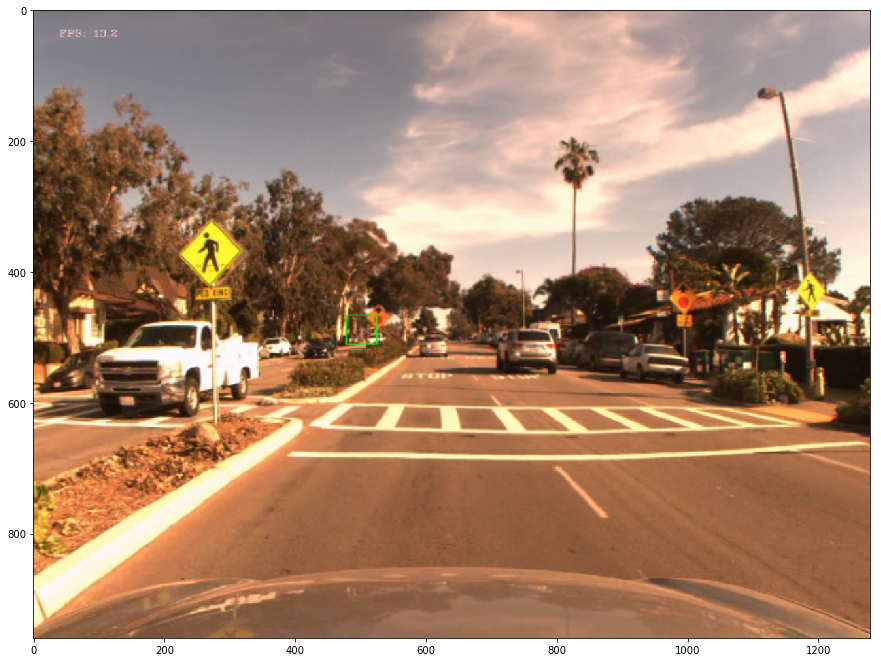

In [6]:
result = boxes_prediction

bboxes = []
for box, score, cls in zip(result, scores_prediction, classes_prediction):
    y1, x1, y2, x2 = box.astype(np.int)
    print("Found a '{}' at {} with {:-2f}%".format(CATEGORIES[cls], (x1, y1, x2, y2), 100*score))
    bboxes.append(Box(x1, y1, x2, y2, cls, score))

result = draw(img, bboxes, color=[0, 255, 0],thickness=1)
result = cv2.resize(result,  (1280, 960))
plt.figure(figsize=(15, 15))

plt.imshow(result)
print(img.shape)